Graph Neural Network with NetworkX - StellarGraph 

Algorithm Selection for the Travelling Salesman Problem

In [ ]:
!pip install -q stellargraph

     |████████████████████████████████| 435 kB 5.4 MB/s 
     |████████████████████████████████| 462 kB 87.9 MB/s 


In [ ]:
import os
import csv
import time 
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN,GAT
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification

from sklearn.datasets import load_files
from sklearn.metrics import classification_report
from sklearn import model_selection, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.neighbors import KDTree

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D,Conv2D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/GECCO-2022/All-6Set.zip" "/content/"

In [ ]:
!mkdir "/content/all"
!unzip "/content/All-6Set.zip" -d "/content/all"


In [ ]:
def extractTSPparams(file_path):
  instance = []
  lines = []

  start = 0
  with open(file_path) as f:
    lines = f.read().splitlines()
    #print(lines)
  for i in range(start, len(lines)-1):
    line = lines[i].split(",")
    instance.append([float(line[0]),float(line[1])])
  #print(instance)
  return instance

In [ ]:
def extractKPparams(file_path):
  objects = []
  lines = []

  start = 0
  with open(file_path) as f:
    lines = f.read().splitlines()

  capacity = lines[start][0]
  for i in range(start+1, len(lines)-1):
    line = lines[i].split( )
    objects.append([int(line[0]),int(line[1])])
  #print(instance)
  return capacity, objects

In [ ]:
def extractGCSynthicparams(file_path):
  instance = []
  lines = []
  #problem data start at line 0
  start = 0
  with open(file_path) as f:
    lines = f.read().splitlines()

  for i in range(start, len(lines)-1):
    line = lines[i].split(",")
    instance.append([int(line[0]),int(line[1])])
  #print(instance)
  return instance

In [ ]:
rootdir = '/content/all/CHR/'
TSPinstances = []
TSPlabels = []
AllLabels = []
instances_num = 2500

for dir,subdir,files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    #print(file_path)
    instanceName = file[:-4]
    TSPinstance = (instanceName, extractTSPparams(file_path))
    #if TSPinstance[1] != []:
    if len(TSPinstance[1]) > 5:        
      TSPinstances.append(TSPinstance)
      TSPlabels.append(0)
      AllLabels.append(0)
    else:
      print(instanceName + " has no vertex!")

rootdir = '/content/all/GREEDY/'

for dir,subdir, files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    
    instanceName = file[:-4]
    TSPinstance = (instanceName, extractTSPparams(file_path))
    #if TSPinstance[1] != []:  
    if len(TSPinstance[1]) > 5:           
      TSPinstances.append(TSPinstance)
      TSPlabels.append(1)
      AllLabels.append(1)
    else:
      print(instanceName + " has no vertex!")
TSPlabels = pd.DataFrame(TSPlabels)

rootdir = '/content/all/Expknap/'

KPinstances = []
KPlabels = []

for dir,subdir,files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    #print(file_path)
    instanceName = file[:-4]
    KP_capacity, KP_objects = extractKPparams(file_path)
    KPinstance = (instanceName, KP_capacity, KP_objects)
     
    KPinstances.append(KPinstance)
    KPlabels.append(2)
    AllLabels.append(2)

rootdir = '/content/all/Combo/'

for dir,subdir,files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    #print(file_path)
    instanceName = file[:-4]
    KP_capacity, KP_objects = extractKPparams(file_path)
    KPinstance = (instanceName, KP_capacity, KP_objects)
     
    KPinstances.append(KPinstance)
    KPlabels.append(3)
    AllLabels.append(3)

KP_labels = pd.DataFrame(KPlabels)

rootdir = '/content/all/DSATUR/'
GCinstances = []
GClabels = []
instances_num = 2500

for dir,subdir,files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    #print(file_path)
    instanceName = file[:-4]
    GCinstance = (instanceName, extractGCSynthicparams(file_path))
    if GCinstance[1] != []:        
      GCinstances.append(GCinstance)
      GClabels.append(4)
      AllLabels.append(4)
    else:
      print(instanceName + " has no edges!")

rootdir = '/content/all/LF/'

for dir,subdir, files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    
    instanceName = file[:-4]
    GCinstance = (instanceName, extractGCSynthicparams(file_path))
    if GCinstance[1] != []:        
      GCinstances.append(GCinstance)
      GClabels.append(5)
      AllLabels.append(5)
    else:
      print(instanceName + " has no edges!")
GClabels = pd.DataFrame(GClabels)


In [ ]:
AllLabels = pd.DataFrame(AllLabels)
target_encoding = preprocessing.LabelBinarizer()
target_encoding.fit_transform(AllLabels)
AllLabels = target_encoding.transform(AllLabels)

In [ ]:
KPinstances_norm = []

for inst in KPinstances:
  a2 = [[i / sum(j) for i in j] for j in inst[2]]
  KPinstances_norm.append((inst[0],inst[1],a2))

In [ ]:
instancesG = []

nxInstances = []
counter = 0
for instance in TSPinstances:
  tempG = nx.Graph(name = instance[0])
  tree = KDTree(instance[1], leaf_size=2)  
  g = nx.Graph()
  for i in range(0,len(instance[1])): 
    tempG.add_node(i, coord=instance[1][i])
    dist, ind = tree.query([[instance[1][i][0],instance[1][i][1]]] , k=5)  
    for j in ind[0][1:]:
      distance = math.sqrt(((instance[1][i][0]-instance[1][j][0])**2)+((instance[1][i][1]-instance[1][j][1])**2))
      tempG.add_edge(i,j, weight=distance)
      tempG.add_edge(j,i, weight=distance) 
  SG = StellarGraph.from_networkx(tempG, node_features="coord")
  instancesG.append(SG)
  nxInstances.append(tempG)  

#instancesKP = []
#instancesKPNX = []
counter = 0

for instance in KPinstances_norm:
  tempG = nx.Graph(name = instance[0])
  tempG.add_node(0, profitweight=[0,math.log(float(instance[1]))])
  for count, vals in enumerate(instance[2]):
    tempG.add_node(count+1, profitweight=[vals[0], vals[1]])
    tempG.add_edge(0, count+1)

  #instancesKPNX.append(tempG)
  SG = StellarGraph.from_networkx(tempG, node_features="profitweight")
  instancesG.append(SG)
  if(len(instance[1])==0):
    print("empty")
    print(counter)
  counter = counter +1
  nxInstances.append(tempG)  

counter = 0
for instance in GCinstances:
  tempG = nx.Graph(name = instance[0])
  for count, vals in enumerate(instance[1]):    
    tempG.add_edge(vals[0], vals[1])
  for node in tempG.nodes:
    tempG.nodes[node]["feature"] = (tempG.degree[node],0)  ##padding
    #tempG.nodes[node]["feature"] = (1,)
  #instancesGCNX.append(tempG)
  SG = StellarGraph.from_networkx(tempG, node_features="feature")
  instancesG.append(SG)
  nxInstances.append(tempG)  


generator = PaddedGraphGenerator(graphs=instancesG)
#ClusterNodeGenerator 

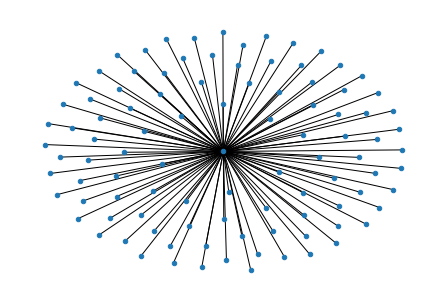

In [ ]:
nx.draw(nxInstances[5010], node_size=20)

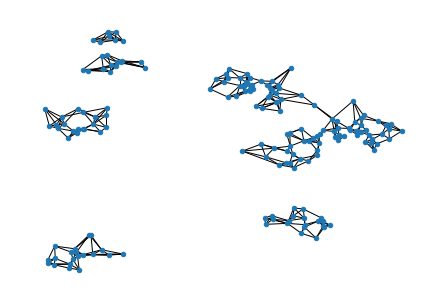

In [ ]:
G =nxInstances[2752]

nx.draw(G, pos=nx.get_node_attributes(G, 'coord'),node_size=20)

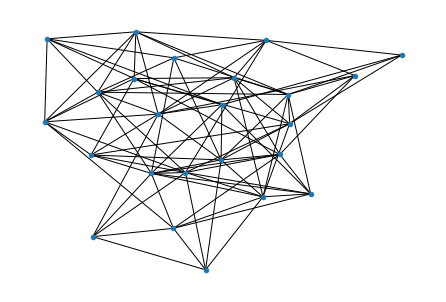

In [ ]:
nx.draw(nxInstances[14124], node_size=20)

In [ ]:
TSPinstances = []
files = []


In [ ]:
def DGCNN(generator):
  model = DeepGraphCNN(
                 layer_sizes=[32, 32, 32, 1],
                 activations=["tanh","tanh", "tanh", "tanh"],
                 generator=generator,
                 k=32
    )
  x_inp, x_out = model.in_out_tensors()

  x_out = Conv1D(filters=16, kernel_size=64, strides=64)(x_out)
  x_out = MaxPool1D(pool_size=1)(x_out)
  x_out = Conv1D(filters=32, kernel_size=8, strides=1)(x_out)
  x_out = Flatten()(x_out)
  x_out = Dense(units=258, activation="relu")(x_out)
  x_out = Dropout(rate=0.5)(x_out)
  predictions = Dense(units=1, activation="sigmoid")(x_out)

  model = Model(inputs=x_inp, outputs=predictions)
  return model

def GCN(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[32, 32],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    #predictions = Dense(units=6, activation="sigmoid")(predictions)
    predictions = Dense(units=6, activation="softmax")(predictions)
    model = Model(inputs=x_inp, outputs=predictions)
    return model

def GATmodel(generator):
  gat = GAT(
    layer_sizes=[32, 32],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
  )
  x_inp, x_out = gat.in_out_tensors()
  predictions = Dense(units=32, activation="relu")(x_out)
  predictions = Dense(units=16, activation="relu")(predictions)
  predictions = Dense(units=1, activation="sigmoid")(predictions)

  # Let's create the Keras model and prepare it for training
  model = Model(inputs=x_inp, outputs=predictions)
  return model



In [ ]:
def train_fold(model, train_gen, test_gen, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=1
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen)
    test_acc = test_metrics
    #print(test_metrics)
    #print(test_gen)
    predicted_y = model.predict(test_gen)
    #print(predicted_y)
    return (history, test_acc, test_gen.targets,predicted_y)

In [ ]:
epochs = 100  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

In [ ]:
def get_GC_generators(GC_train_index, GC_test_index, graph_labels, batch_size):
    GC_train_gen = generator.flow(
       # GC_train_index, targets=graph_labels.iloc[GC_train_index].values, batch_size=batch_size
       GC_train_index, targets=graph_labels[GC_train_index], batch_size=batch_size
    )
    GC_test_gen = generator.flow(
       # GC_test_index, targets=graph_labels.iloc[GC_test_index].values, batch_size=batch_size
       GC_test_index, targets=graph_labels[GC_test_index], batch_size=batch_size
    )

    return GC_train_gen, GC_test_gen

In [ ]:
test_accs2 = []
alltests = []
allpredictions = []

cv = KFold(n_splits=folds, random_state=1, shuffle=True)
f = 1
for train_index, test_index in cv.split(AllLabels, AllLabels):
    print(f"Training and evaluating on fold {f} out of {folds * n_repeats}...")
    train_gen2, test_gen2 = get_GC_generators(
        train_index, test_index, AllLabels, batch_size=1
    )

    gnnmodel = GCN(generator)
    gnnmodel.compile(optimizer=Adam(learning_rate=0.00005), loss=categorical_crossentropy)
    history = train_fold(gnnmodel, train_gen2, test_gen2, epochs)
    alltests.append(history[2])
    allpredictions.append(history[3])
    test_accs2.append(history[1])
    f +=1

In [ ]:
predictions = []
for sublist in allpredictions:
    for item in sublist:      
        predictions.append(item)


tests = []
for sublist in alltests:
    for item2 in sublist:
        tests.append(item2)

In [ ]:
print(predictions)

In [ ]:
allrepo=classification_report(tests, predictions, output_dict=True)
print(allrepo)

In [ ]:
df = pd.DataFrame(allrepo).transpose()
df.to_latex('GNN-All-6.tex')


In [ ]:
!mv GNN-All-6.tex "/content/drive/MyDrive/Colab Notebooks/GECCO-2022/"

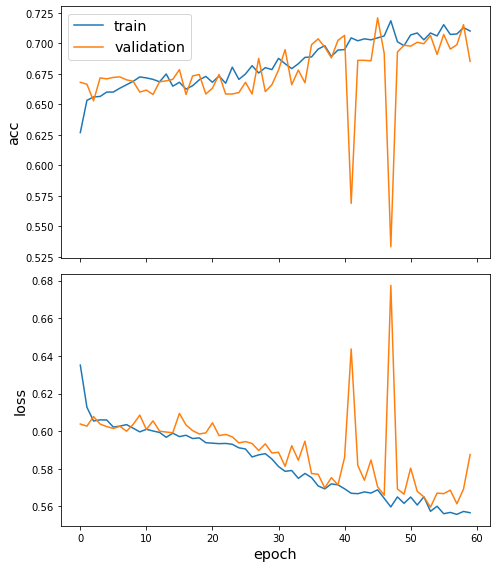

In [ ]:
sg.utils.plot_history(history)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=13)